In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/diamonds/diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [3]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

# EDA

## Data cleaning

### Let's see variables' distribution

In [4]:
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


### The price can't be negative or zero

In [5]:
df = df[df['price'] > 0]

### X, Y and Z have to be non-negative

In [6]:
df = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)]

## Let's make some plots

## Univariate analysis

### Most of the diamonds have an ideal cut

<Axes: xlabel='count', ylabel='cut'>

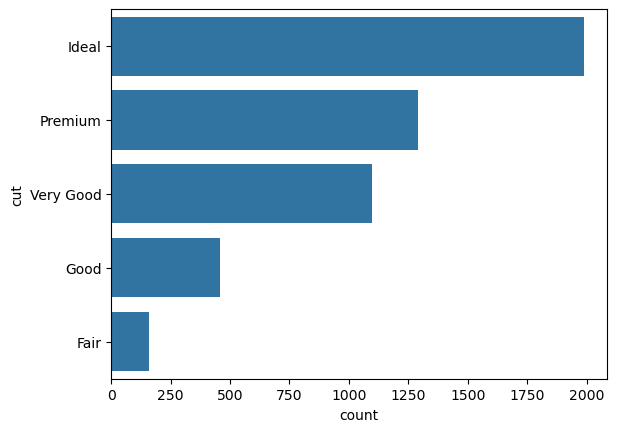

In [7]:
sns.countplot(df['cut'])

### Good color diamons are common

<Axes: xlabel='count', ylabel='color'>

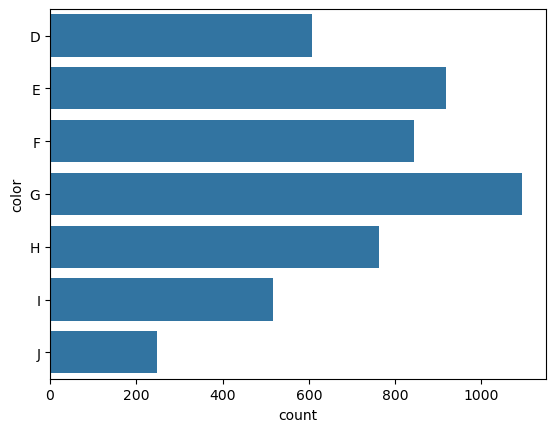

In [8]:
sns.countplot(df['color'], order=df['color'].sort_values())

### Bad clarity diamonds are very normal

<Axes: xlabel='count', ylabel='clarity'>

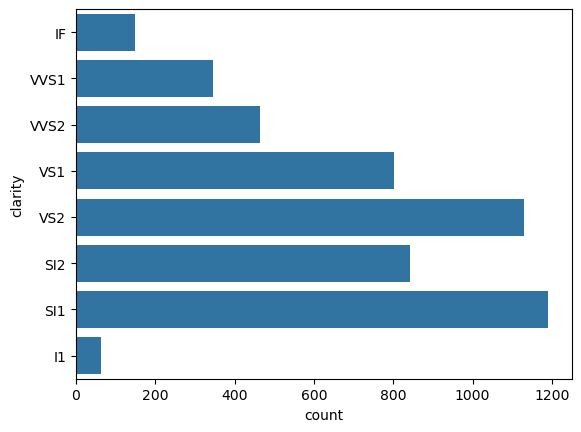

In [9]:
sns.countplot(df['clarity'], order=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI2', 'SI1', 'I1'])

### Carat, table and price are right-skewed, while the other variables are zero skewed.
### Also, variables have different ranges

In [10]:
numerical_columns = list(df.select_dtypes(include=np.number).columns)
categorical_columns = list(df.select_dtypes(exclude=np.number).columns)

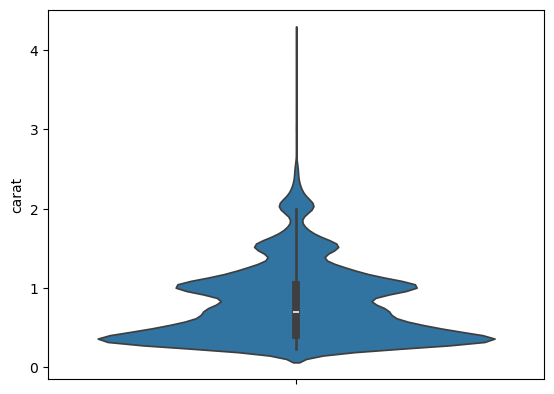

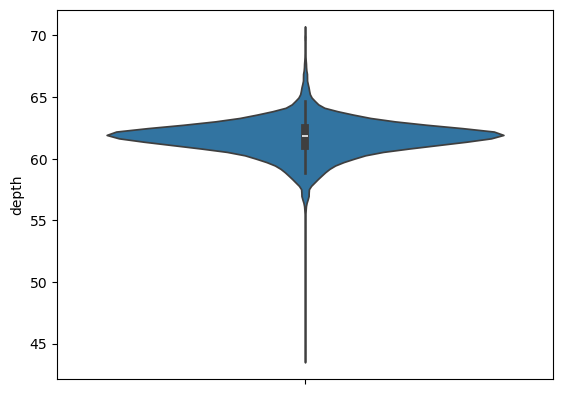

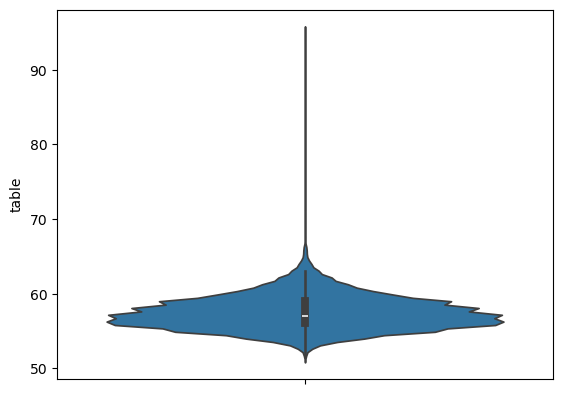

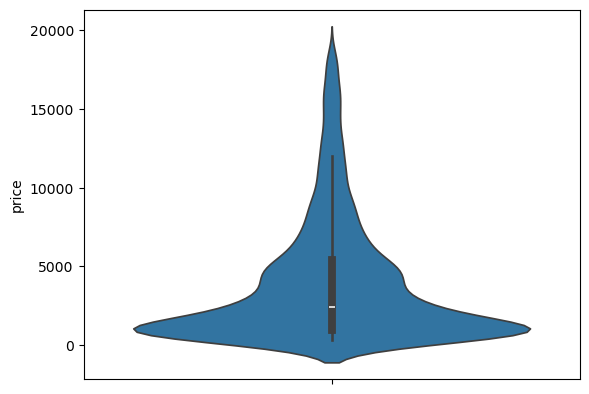

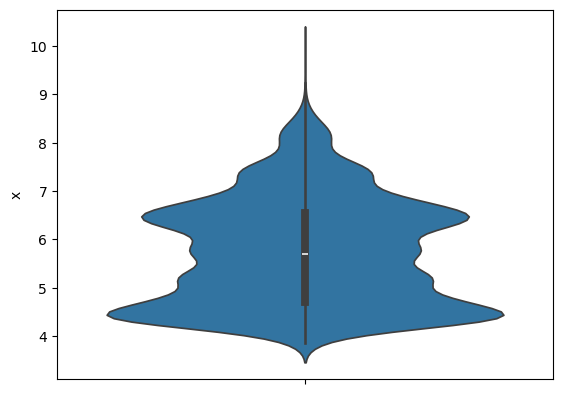

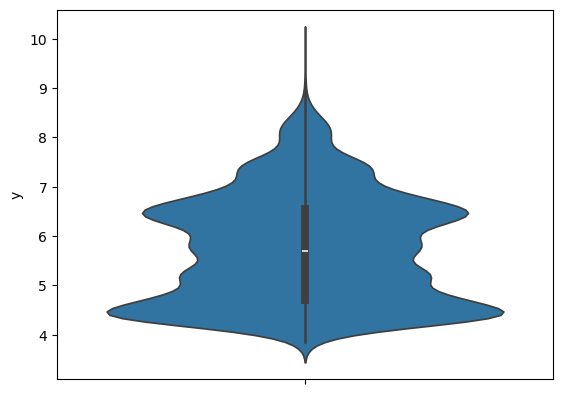

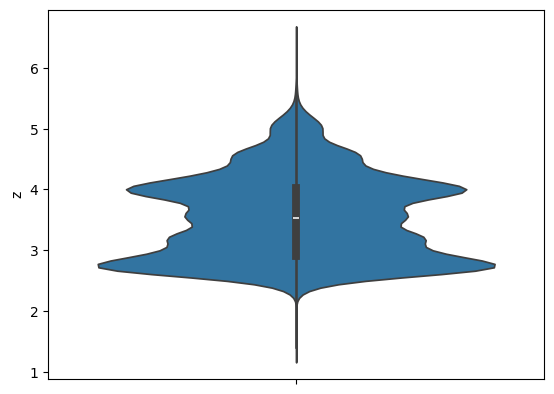

In [11]:
for column in df.columns:
    if column in numerical_columns:
        fig, ax = plt.subplots()
        ax = sns.violinplot(df[column])
plt.show()

In [12]:
df[numerical_columns].skew()

carat    1.076086
depth   -0.449439
table    1.478767
price    1.587464
x        0.377719
y        0.369058
z        0.375837
dtype: float64

### Table and depth are leptokurtic but the rest are mesokurtic

In [13]:
df[numerical_columns].kurtosis()

carat     1.157125
depth     7.114036
table    15.525537
price     2.079043
x        -0.748260
y        -0.767157
z        -0.710927
dtype: float64

## Bivariate analysis

### Surprisingly, fair and premium diamonds tend to be more expensive. Also, ideal diamonds has the lower median

<Axes: xlabel='price', ylabel='cut'>

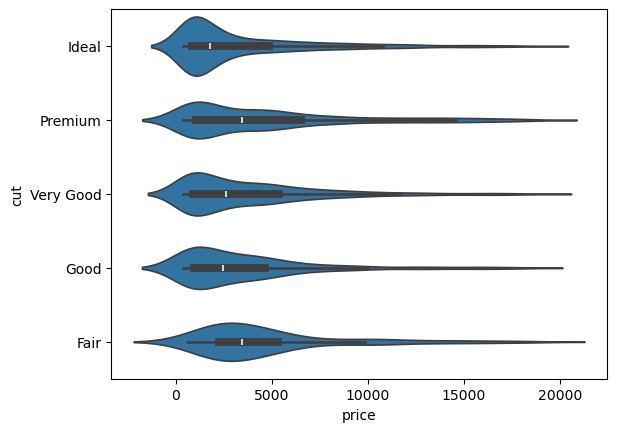

In [14]:
sns.violinplot(x='price', y='cut', data=df)

### J and I diamons are rare and expensive, while the best diamonds are common and cheap

<Axes: xlabel='price', ylabel='color'>

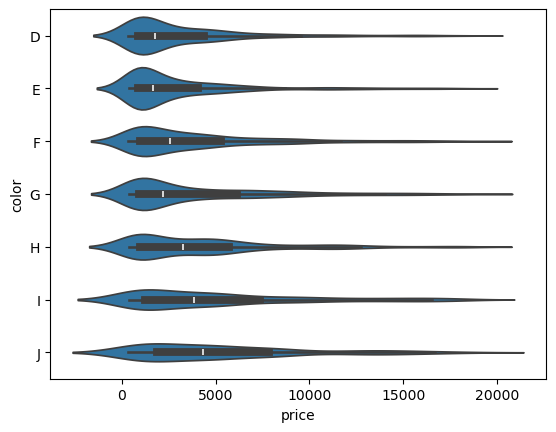

In [15]:
sns.violinplot(x='price', y='color', data=df, order=['D', 'E', 'F', 'G', 'H', 'I', 'J'])

### Mostly clarity categories are right skewed regarding price

<Axes: xlabel='price', ylabel='clarity'>

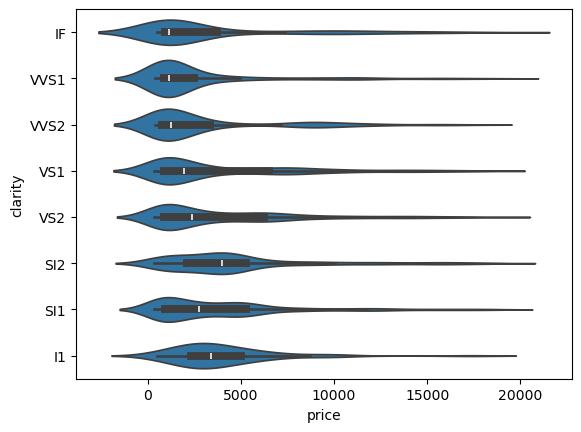

In [16]:
sns.violinplot(x='price', y='clarity', data=df, order=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI2', 'SI1', 'I1'])

### x, y, z and carat apparently have a high correlation with price


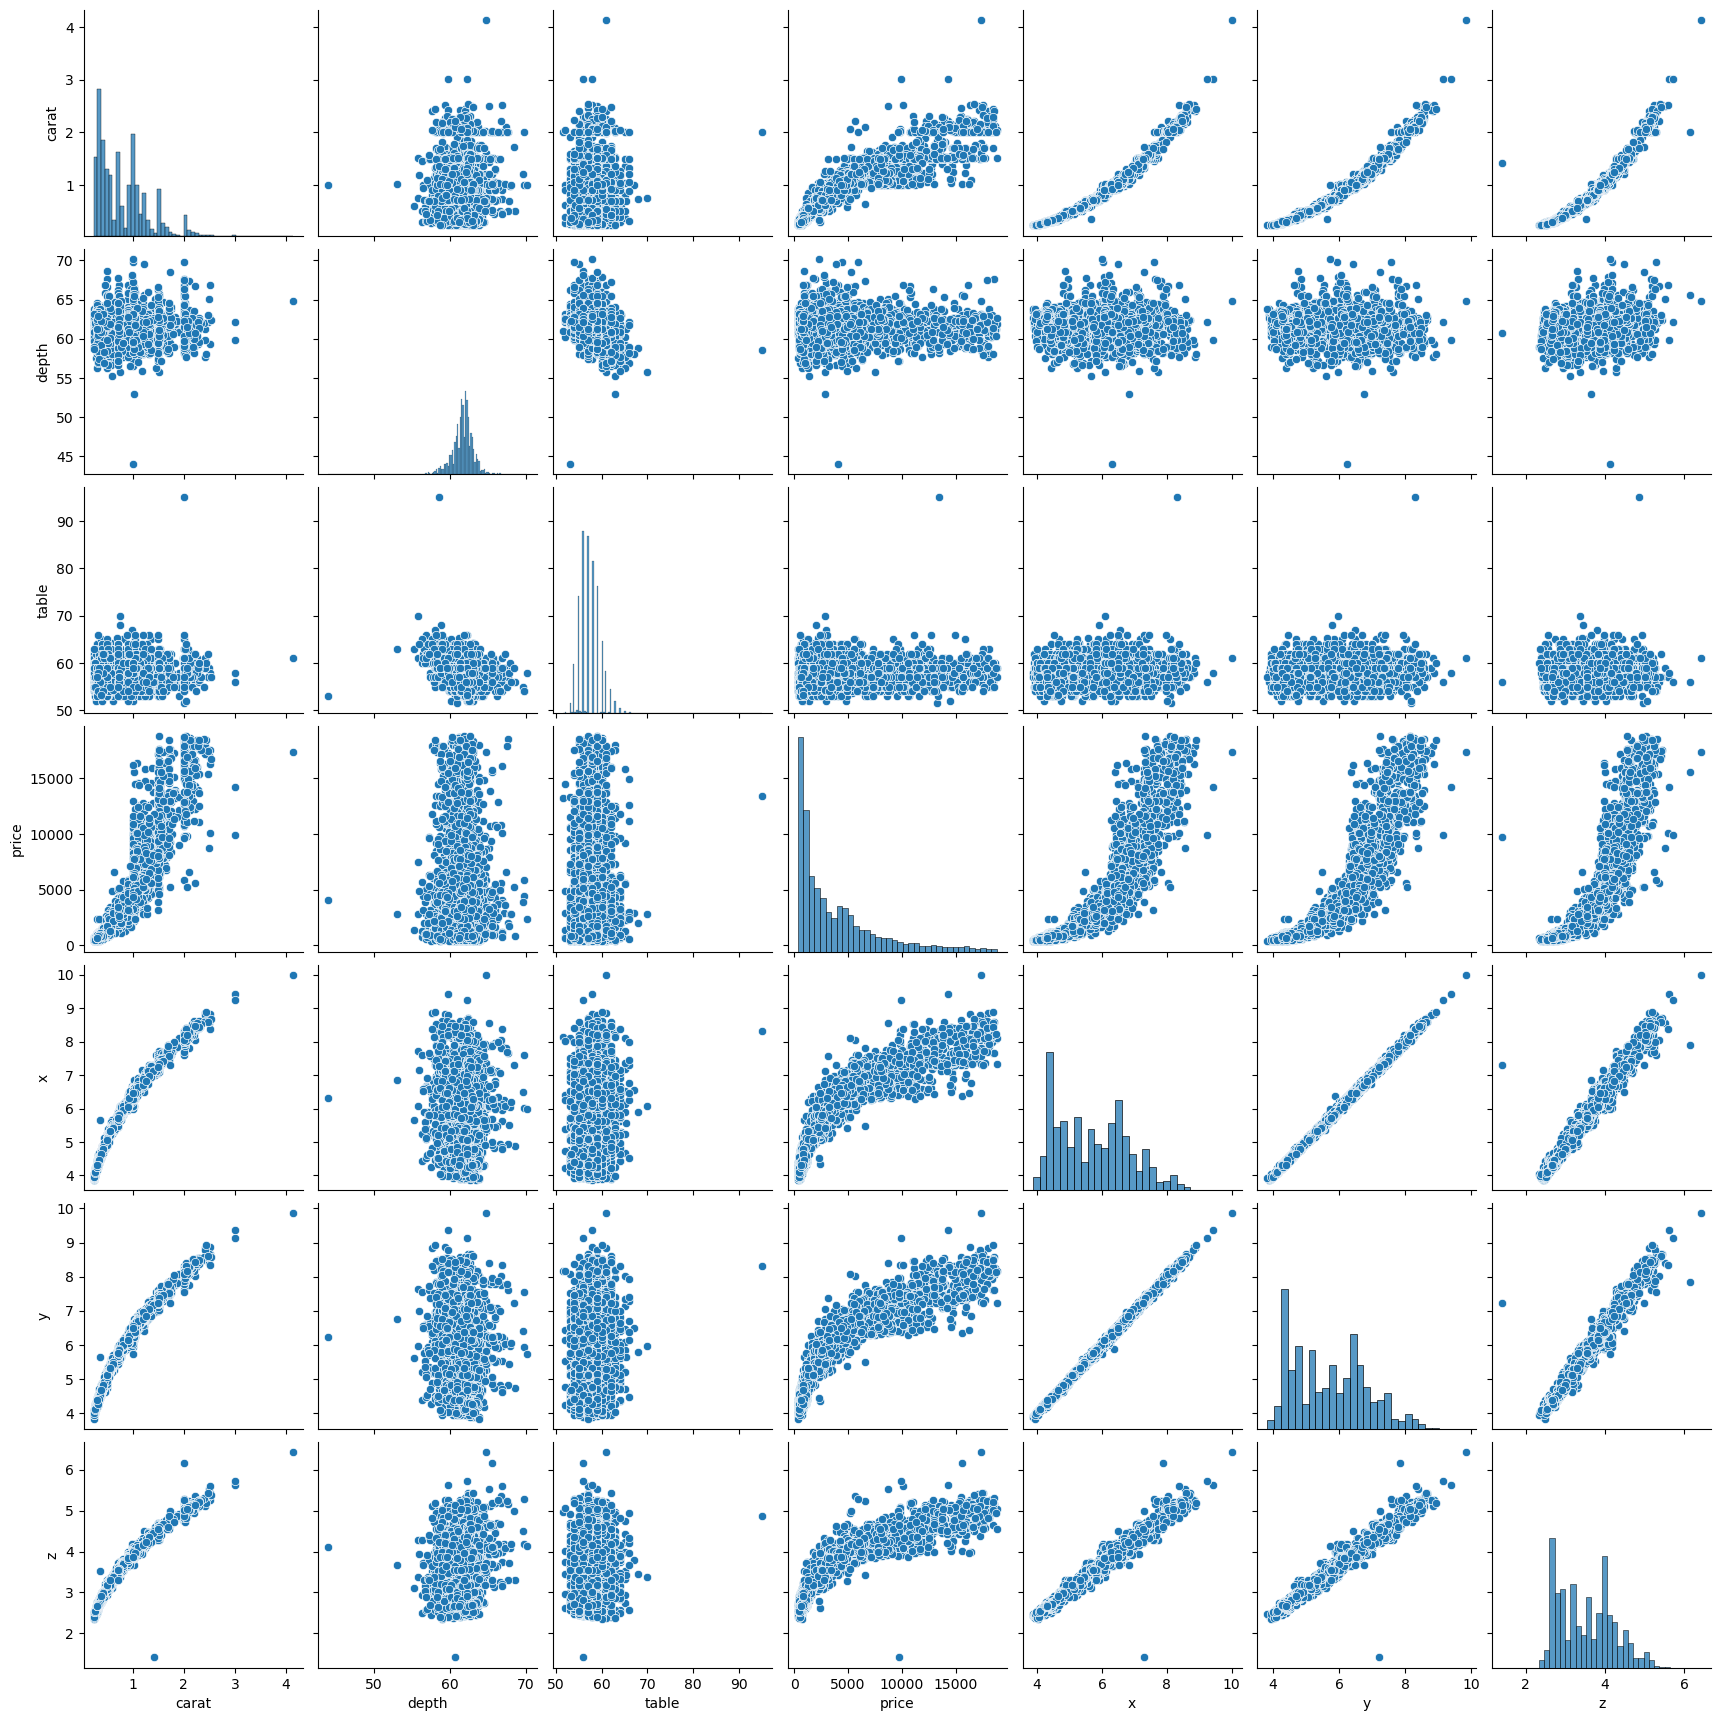

In [17]:
sns.pairplot(df)

# Feature engineering

## Feature creation

In [18]:
df['size'] = df['x']*df['y']*df['z']

<Axes: xlabel='size', ylabel='price'>

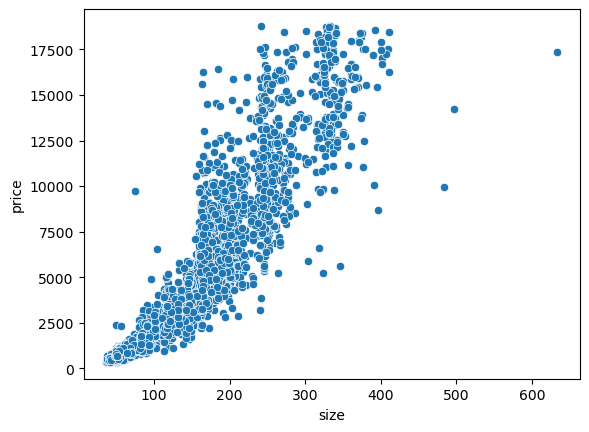

In [19]:
sns.scatterplot(x='size', y='price', data=df)

### Categorical encoding

I'm not a domain expert so I'm going to rely on target's distribution

In [20]:
from sklearn.preprocessing import TargetEncoder

target_encoder = TargetEncoder(target_type='continuous', smooth="auto", cv=10)
df[categorical_columns] = target_encoder.fit_transform(df[categorical_columns], df['price'])

<Axes: >

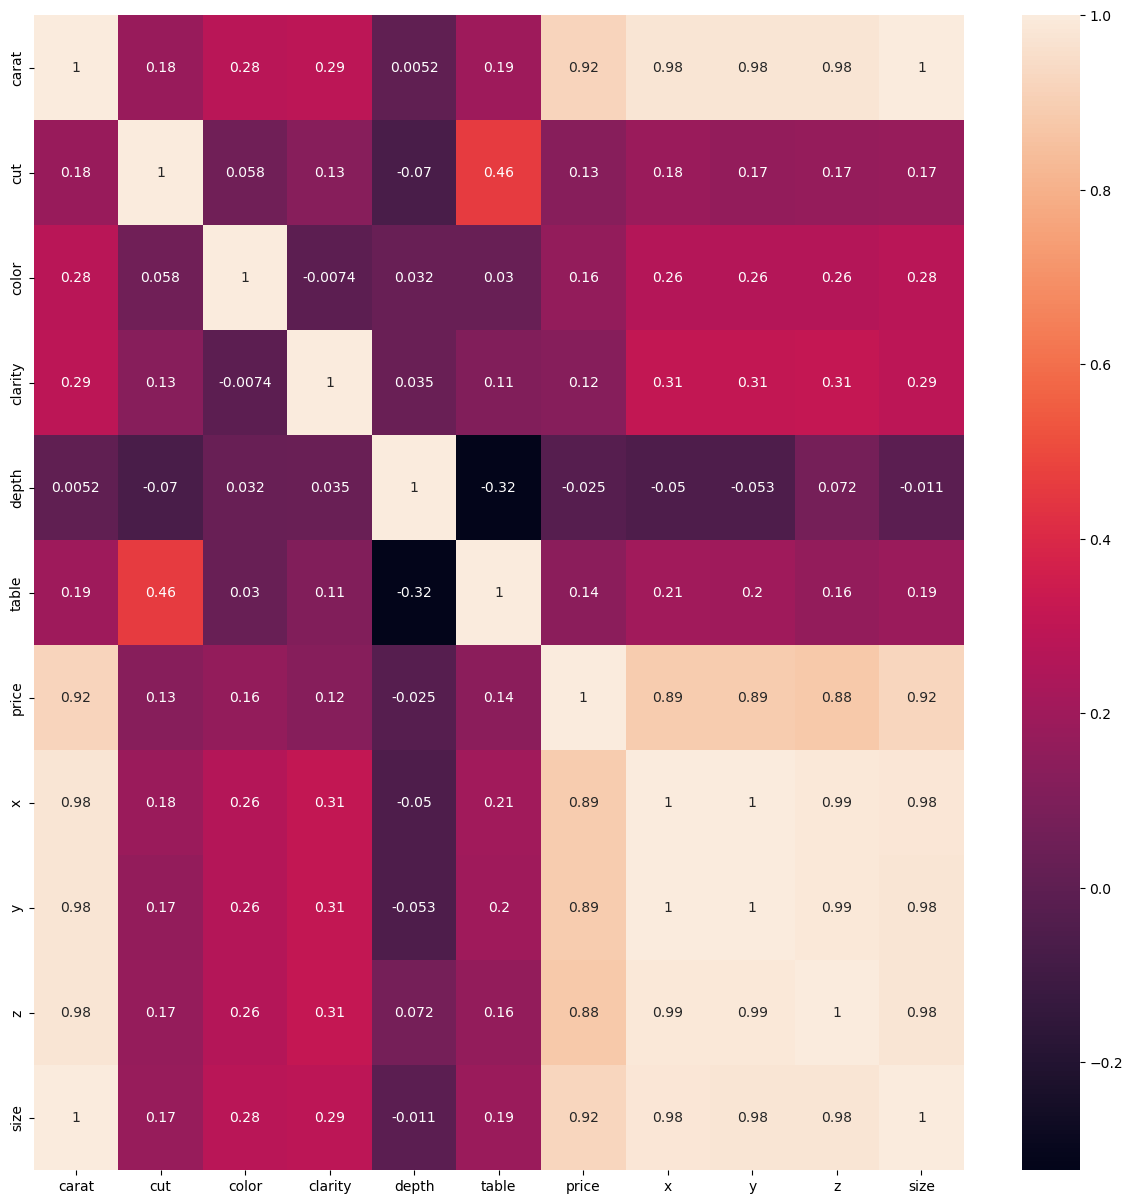

In [21]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True)

# Modeling

## Feature selection

In [122]:
from sklearn.model_selection import train_test_split

X = df[['size', 'color', 'clarity']]
# I use logarithm because the target is skewed
y = np.log(df['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)

### Scaling

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Baseline model

In [124]:
from sklearn.linear_model import Lasso

modelLasso = Lasso(alpha=0.1)

In [125]:
from sklearn.model_selection import cross_val_score

cross_val_score(modelLasso, X_train, y_train, scoring='r2', cv=10)

array([0.81819273, 0.83626969, 0.85098652, 0.84406101, 0.84938859,
       0.84225852, 0.84625932, 0.84751835, 0.85812693, 0.86106818])

In [126]:
from sklearn.metrics import r2_score, mean_squared_error

modelLasso.fit(X_train, y_train)
train_preds = modelLasso.predict(X_train)
print(f"Squared R for train is: {r2_score(y_train, train_preds)}")
print(f"MSE for train is: {mean_squared_error(np.exp(y_train), np.exp(train_preds))}")
test_preds = modelLasso.predict(X_test)
print(f"Squared R for test is: {r2_score(y_test, test_preds)}")
print(f"MSE for test is: {mean_squared_error(np.exp(y_test), np.exp(test_preds))}")

Squared R for train is: 0.8461264285464849
MSE for train is: 17905192.428678114
Squared R for test is: 0.8202942370180555
MSE for test is: 524371245.83840275


Lasso regression has an acceptable performance in terms of $R^{2}$ but MSE is really high. Lets try other algorithms!

## Random search


In [127]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
def experiment(algorithm, metric, hyperparameters, X_train, y_train, X_test, y_test):
    model = algorithm()
    best_regressor = RandomizedSearchCV(model, hyperparameters, scoring=make_scorer(metric), cv=10)
    best_regressor.fit(X_train, y_train)
    preds = best_regressor.predict(X_test)
    score_test = metric(y_test, preds)
    print(f"The {metric} for algorithm {algorithm} is {round(best_regressor.best_score_, 3)} \
    for train and {round(score_test, 3)} for test. The best params are {best_regressor.best_params_}")
    return best_regressor.best_estimator_, best_regressor.best_score_

In [128]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

hyperparams = {
    Lasso: {'alpha': [5e-3, 1e-2, 5e-2, 1e-1, 1, 5, 10, 20, 50, 100]},
    KNeighborsRegressor: {'n_neighbors': [i for i in range(1,20)]},
    XGBRegressor: {
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1], 
        'max_depth': [i for i in range(3,10)], 
        'min_child_weight': [i for i in range(1,10,2)],
        'gamma': [i/10 for i in range(10)]
    }
}

results = list(map(lambda x: experiment(x[0], r2_score, x[1], X_train, y_train, X_test, y_test), hyperparams.items()))

The <function r2_score at 0x7f9d2bcb9630> for algorithm <class 'sklearn.linear_model._coordinate_descent.Lasso'> is 0.877     for train and 0.853 for test. The best params are {'alpha': 0.005}
The <function r2_score at 0x7f9d2bcb9630> for algorithm <class 'sklearn.neighbors._regression.KNeighborsRegressor'> is 0.969     for train and 0.96 for test. The best params are {'n_neighbors': 4}
The <function r2_score at 0x7f9d2bcb9630> for algorithm <class 'xgboost.sklearn.XGBRegressor'> is 0.979     for train and 0.963 for test. The best params are {'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.0}


XGBoost had the best results. Second place for KNN. Let's validate XGBoost model

## Validation

In [129]:
import functools
# get model with best metric
model = functools.reduce(lambda x, y: x if x[1] > y[1] else y, results)[0]
model.fit(X_train, y_train)
preds = model.predict(X_train)
mean_squared_error(np.exp(y_train), np.exp(preds))

129573.22507770748

<Axes: title={'center': 'Residual plot train'}, xlabel='price'>

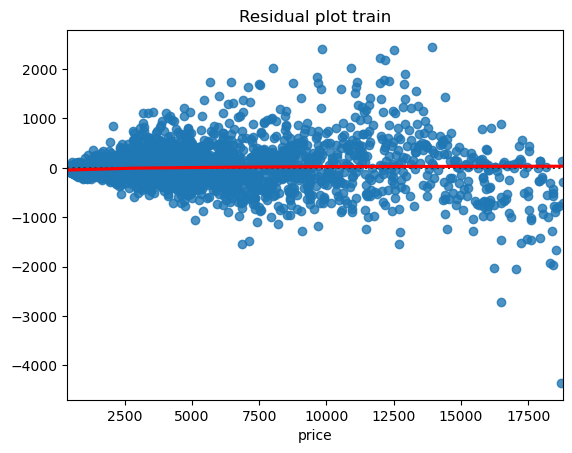

In [130]:
plt.title("Residual plot train")
sns.residplot(x=np.exp(y_train), y=np.exp(preds), lowess=True, line_kws=dict(color='r'))

In [131]:
preds_test = model.predict(X_test)
mean_squared_error(np.exp(y_test), np.exp(preds_test))

925653.7956057918

<Axes: title={'center': 'Residual plot test'}, xlabel='price'>

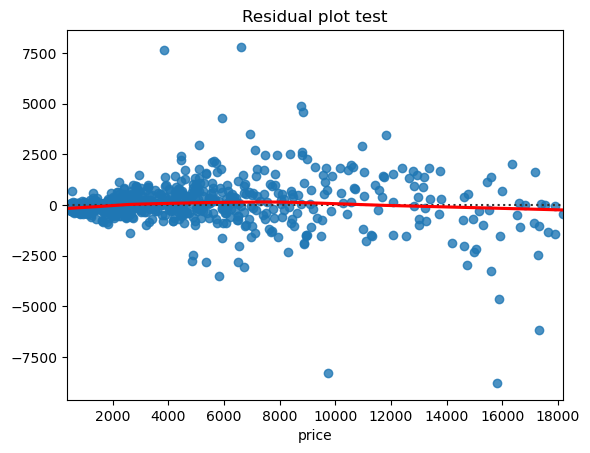

In [132]:
plt.title("Residual plot test")
sns.residplot(x=np.exp(y_test), y=np.exp(preds_test), lowess=True, line_kws=dict(color='r'))

The residual barely grows, homoscedasticity check passed!

In [136]:
import joblib
joblib.dump(target_encoder, 'encoder.sav')
joblib.dump(scaler, 'scaler.sav')
model.save_model("diamonds_model.json")

# Conclusion

First of all, the quality of the data was awesome. No missing values and a few registers had an inappropiate value. That's really important for modelling. The target variable had to be changed with a logarithm because it is skewed. Then, after comparing three algorithms I can conclude that XGBoost was the best. Surprisingly, KNN performed better than Lasso. The final model has great R^2 and MSE values. Also I validated it with residual plots.